In [3]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

In [4]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [5]:
#torch.manual_seed(42)
#np.random.seed(42)

In [6]:
class HeatPINN(nn.Module):
    def __init__(self, layers):
        super(HeatPINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.hidden_layers.append(nn.Linear(layers[i-1], layers[i]))

    def forward(self, x_t):
        for layer in self.hidden_layers[:-1]:
            x_t = torch.tanh(layer(x_t))
        x_t = self.hidden_layers[-1](x_t)
        return x_t
    
    def compute_gradients(self, x_t):
        x_t.requires_grad = True

        u = self.forward(x_t)

        u_x = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 0]
        u_xx = torch.autograd.grad(outputs=u_x, inputs=x_t, grad_outputs=torch.ones_like(u_x), create_graph=True, allow_unused=True)[0][:, 0]
        u_t = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 1]
        return u, u_x, u_xx, u_t

    def dirichlet_conditions(self, x_t_bc_left_1D, x_t_bc_right_1D, x_t_bc_top, x_t_bc_bottom, g_bottom):
        u_left, _, _, _ = self.compute_gradients(x_t_bc_left_1D)
        u_right, _, _, _ = self.compute_gradients(x_t_bc_right_1D)
        u_top, _, _, _ = self.compute_gradients(x_t_bc_top)
        u_bottom, _, _, _ = self.compute_gradients(x_t_bc_bottom)
        return torch.mean((u_left - 0) ** 2) + \
               torch.mean((u_right - (0)) ** 2) + \
               torch.mean((u_bottom - g_bottom) ** 2)
    
    def neuman_conditions(self, x_t_bc_left_1D):
        _, u_x_left, _, _ = self.compute_gradients(x_t_bc_left_1D)
        return 0#torch.mean((u_x_left - 1) ** 2)

    def loss_fn(self, x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha, g_bottom):
        u, u_x, u_xx, u_t = self.compute_gradients(x_t_train)
        # Placeholder for Poisson equation and f(x_t_train), adjust as per your actual computation
        heat_eq = u_t - a * u_xx - self.f(x_t_train)  # This is a placeholder equation
        bc_dirichlet_loss = self.dirichlet_conditions(x_t_bc_left_1D, x_t_bc_right_1D, x_t_bc_top, x_t_bc_bottom, g_bottom)
        #bc_neuman_loss = self.neuman_conditions(x_t_bc_left_1D)
        return torch.mean(heat_eq**2) + 10 * bc_dirichlet_loss #+ bc_neuman_loss
    
    def f(self, x_t):
        x, t = x_t[:, 0], x_t[:, 1]
        return 0
    
    def exact(self, x_t):
        x, t = x_t[:, 0], x_t[:, 1]
        return torch.sin(torch.pi * x) * torch.exp(-(torch.pi**2)*t)

    

 ∂u/∂t = a * ∂^2u/∂x^2
 
                           ∂u/∂n = 0
                __________________________
                ||                       ||
         u=-1   || t                     || u = -1
                ||          x            ||
                ||_______________________||
                           u = -1

In [7]:
def train(model, optimizer, loss_threshold, x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha, g_bottom):
    model.train()  # Set the model to training mode (affects certain modules like Dropout, BatchNorm, etc.)
    optimizer.zero_grad()
    loss = model.loss_fn(x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha, g_bottom)
    loss_array = []
    epoch = 0
    start_time = time.time()
    try:
        while loss.item() > loss_threshold:
            optimizer.zero_grad()  # Clears old gradients from the last step (otherwise gradients would accumulate)
            
            # Compute the loss based on the provided training and boundary condition data
            loss = model.loss_fn(x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha, g_bottom)
            
            loss.backward()  # Backpropagate the loss to compute gradients
            optimizer.step()  # Adjust model parameters based on the computed gradients

            loss_array.append(loss.item())
            if epoch % 100 == 0:  # Optionally print the loss every 100 epochs
                print(f'Epoch {epoch}, Loss: {loss.item()}')

            epoch += 1
    except KeyboardInterrupt:
        print("Training stopped manually")
            
    print("Training took %s seconds" % (time.time() - start_time))
    print(f"Last epoch: {epoch}, loss: {loss.item()}")

    plt.plot(loss_array)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.title('Mean loss during training')
    plt.show(block=False)


In [11]:
layers = [2, 30, 30, 30, 1]  # Adjusted first layer to accept 2 inputs (x and t)
model = HeatPINN(layers)
optimizer = optim.AdamW(model.parameters(), lr=1e-03)

In [12]:
# Example Data Preparation (Adapt this to your actual data)
a = 1
alpha = 1
N_train_x = 100
N_train_t = 100
N_test_x = 100
N_test_t = 100
N_bc = 100
L_x, R_x = 0.0, 1.0
L_t, R_t = 0.0, 1.0

x_train = np.linspace(L_x, R_x, N_train_x)
t_train = np.linspace(L_t, R_t, N_train_t)
X_train, T_train = np.meshgrid(x_train, t_train)
x_t_train = np.hstack((X_train.flatten()[:, None], T_train.flatten()[:, None]))
x_t_train = torch.tensor(x_t_train, dtype=torch.float32)

x_bc = np.linspace(L_x, R_x, N_bc)
x_t_bc_top = np.hstack((x_bc[:, None], R_t * np.ones_like(x_bc)[:, None]))
x_t_bc_bottom = np.hstack((x_bc[:, None], L_t * np.ones_like(x_bc)[:, None]))
x_t_bc_top_1D = torch.tensor(x_t_bc_top, dtype=torch.float32)
x_t_bc_bottom_1D = torch.tensor(x_t_bc_bottom, dtype=torch.float32)

# Example u values for Dirichlet conditions, replace with actual functions f(t) and g(t)
u_bc_top = torch.ones(len(x_bc), 1)  # u = 1 at the top boundary
u_bc_bottom = torch.zeros(len(x_bc), 1)  # u = 0 at the bottom boundary

# Combine the top and bottom boundary conditions into one tensor
u_bc_top_bottom_1D = torch.cat([u_bc_bottom, u_bc_top], dim=0)

t_bc = np.linspace(L_t, R_t, N_bc)
x_t_bc_left = np.hstack((L_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_right = np.hstack((R_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_left_1D = torch.tensor(x_t_bc_left, dtype=torch.float32)
x_t_bc_right_1D = torch.tensor(x_t_bc_right, dtype=torch.float32)

def g(x_t):
        print(x_t[:,1])
        x, t = x_t[:, 0], x_t[:, 1]
        return torch.sin(torch.pi * x)

g_bottom = g(x_t_bc_bottom_1D)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


Epoch 0, Loss: 3.5224668979644775
Epoch 100, Loss: 1.9432801008224487
Epoch 200, Loss: 1.5656174421310425
Epoch 300, Loss: 1.3453798294067383
Epoch 400, Loss: 1.3157083988189697
Epoch 500, Loss: 1.3002829551696777
Epoch 600, Loss: 1.288761854171753
Epoch 700, Loss: 1.275342345237732
Epoch 800, Loss: 1.2595938444137573
Epoch 900, Loss: 1.2427736520767212
Epoch 1000, Loss: 1.225286602973938
Epoch 1100, Loss: 1.206613540649414
Epoch 1200, Loss: 1.1898119449615479
Epoch 1300, Loss: 1.1740899085998535
Epoch 1400, Loss: 1.1610565185546875
Epoch 1500, Loss: 1.1487481594085693
Epoch 1600, Loss: 1.1372462511062622
Epoch 1700, Loss: 1.1257227659225464
Epoch 1800, Loss: 1.1157057285308838
Epoch 1900, Loss: 1.1068302392959595
Epoch 2000, Loss: 1.0990030765533447
Epoch 2100, Loss: 1.092138648033142
Epoch 2200, Loss: 1.086843490600586
Epoch 2300, Loss: 1.0819400548934937
Epoch 2400, Loss: 1.0776581764221191
Epoch 2500, Loss: 1.0736110210418701
Epoch 2600, Loss: 1.0706169605255127
Epoch 2700, Loss: 1

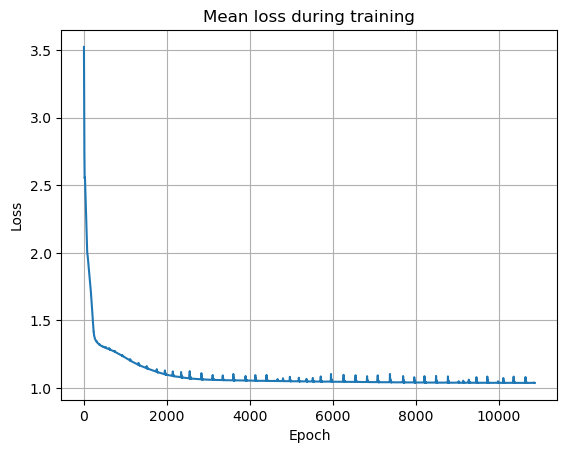

In [13]:
# Training the model
train(model, optimizer, 0.001, x_t_train, x_t_bc_top_1D, x_t_bc_bottom_1D, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha, g_bottom)

Test 1:
    Lambda_1 = 10
    Lambda_2 = 1
    Time = 80m
    loss = 0.034
    MSE with MCE = 3.85%
Test 2:
    

In [14]:
def calculate_max_relative_error(u_pred, u_exact):
    max_diff_index = np.argmax(u_exact - u_pred)
    print("Max difference index:", max_diff_index)
    difference = u_exact - u_pred
    # Find the flattened index of the maximum difference
    max_diff_index_flattened = np.argmax(np.abs(difference))

    # Convert the flattened index to 2D row and column indices
    max_diff_row, max_diff_col = np.unravel_index(max_diff_index_flattened, difference.shape)
    print(f"Row: {max_diff_row}, column: {max_diff_col}")

    # Display the maximum difference
    print("Max difference:", np.abs(difference[max_diff_row, max_diff_col]))

    # Display the elements from both arrays corresponding to the maximum difference
    print("Element from u_exact with max difference:", u_exact[max_diff_row, max_diff_col])
    print("Element from u_pred with max difference:", u_pred[max_diff_row, max_diff_col])
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [15]:
x_test = np.linspace(L_x, R_x, N_test_x)
t_test = np.linspace(L_t, R_t, N_test_t)
X_test, T_test = np.meshgrid(x_test, t_test)
x_t_test = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
x_t_test_tensor = torch.tensor(x_t_test, dtype=torch.float32)

exact_sol = model.exact(x_t_test_tensor)
# Evaluate the model on these points
model.eval()  # Set the model to evaluation mode
u_pred = model(x_t_test_tensor).detach().cpu().numpy()

# Reshape u_pred to match the grid shape
U_pred = u_pred.reshape(X_test.shape)

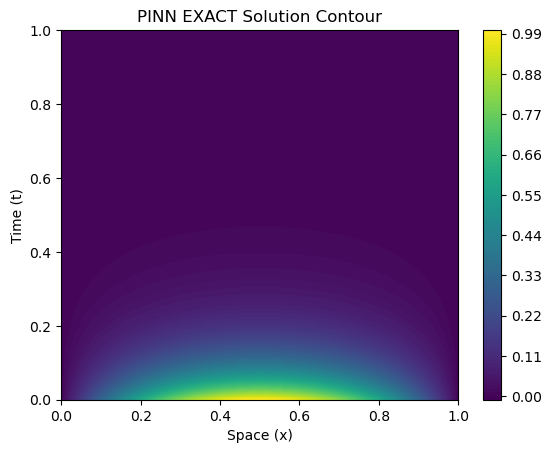

In [16]:
plt.contourf(X_test, T_test, exact_sol.reshape(T_test.shape), levels=100, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN EXACT Solution Contour')
plt.show()

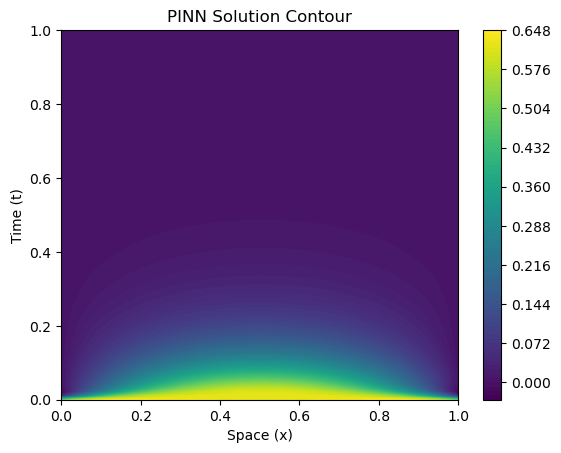

In [17]:
plt.contourf(X_test, T_test, U_pred, levels=100, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN Solution Contour')
plt.show()

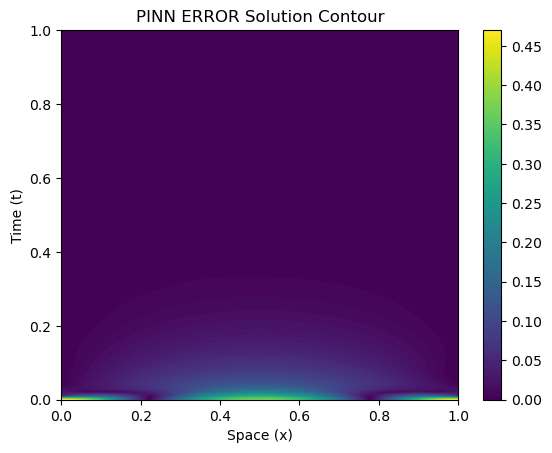

In [18]:
plt.contourf(X_test, T_test, torch.abs(exact_sol.reshape(T_test.shape) - U_pred), levels=100, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN ERROR Solution Contour')
plt.show()

In [24]:
print("Mean Squared Error (PINN and FEM):", np.mean((exact_sol.reshape(T_test.shape).numpy()-U_pred)**2))

relative_error = calculate_max_relative_error(exact_sol.reshape(T_test.shape).numpy(), U_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")

Mean Squared Error (PINN and FEM): 0.0017055704
Max difference index: 1
Row: 0, column: 1
Max difference: 0.4675169
Element from u_exact with max difference: 0.49924484
Element from u_pred with max difference: 0.031727932
Relative error (PINN and FEM): 42.65%


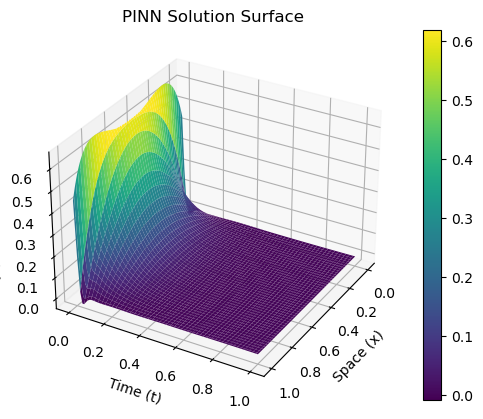

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_test, T_test, U_pred, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Solution (u)')
ax.set_title('PINN Solution Surface')
ax.view_init(elev=30, azim=30)
plt.show()

Solving useing FEM
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


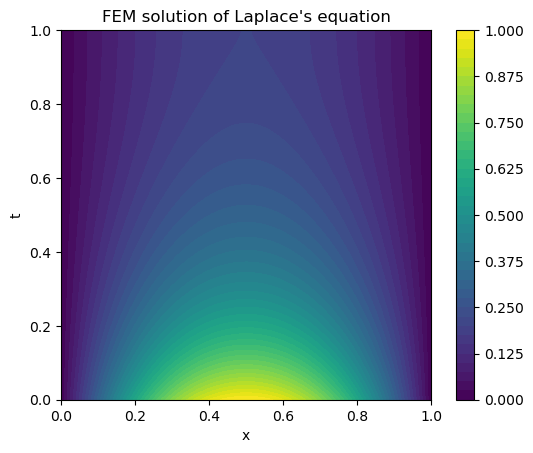

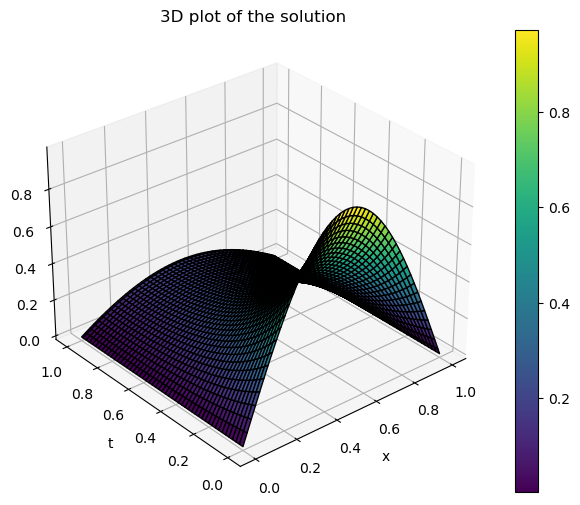

Mean Squared Error (PINN and FEM): 0.05616426544422277
Max difference index: 1
Row: 16, column: 49
Max difference: 0.48283035835415045
Element from u_exact with max difference: 0.16897482
Element from u_pred with max difference: 0.6518051751533143
Relative error (PINN and FEM): 49.59%


In [25]:
print("Solving useing FEM")
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

L, W = 1.0, 1.0  # Length and Width of the rectangle
mesh = RectangleMesh(Point(0, 0), Point(L, W), N_train_x, N_train_t)
V = FunctionSpace(mesh, 'P', 1)
n = FacetNormal(mesh)

# Define boundary conditions
def boundary_left(x, on_boundary):
    return on_boundary and near(x[0], L_x)

def boundary_right(x, on_boundary):
    return on_boundary and near(x[0], R_x)

def boundary_bottom(x, on_boundary):
    return on_boundary and near(x[1], L_t)

g_expression = Expression('sin(pi*x[0])', degree=2)

bc_left = DirichletBC(V, Constant(0), boundary_left)
bc_right = DirichletBC(V, Constant(0), boundary_right)
bc_bottom = DirichletBC(V, g_expression, boundary_bottom)

# Define Robin condition on the left boundary
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0)

# Initialize mesh function for boundary domains
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
bottom_boundary = BottomBoundary()
bottom_boundary.mark(boundaries, 1)

# Define measure for integrating over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

bcs = [bc_left, bc_right, bc_bottom]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1)  # Assuming a source term
g = Constant(0)  # Assuming g on the Robin boundary is 0 for simplicity
alpha_c = Constant(alpha)
a_C = Constant(a)
left_side = a_C*dot(grad(u), grad(v))*dx
right_side = f*v*dx

# Compute solution
u_fenics_app = Function(V)
solve(left_side == right_side, u_fenics_app, bcs)


# Plot solution using matplotlib
c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution of Laplace's equation")
plt.xlabel('x')
plt.ylabel('t')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x, R_x, N_test_x)
t = np.linspace(L_t, R_t, N_test_t)
X, T = np.meshgrid(x, t)
points = np.vstack((X.ravel(), T.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u_fenics_app(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fenics_grid = u_fenics.reshape((len(x), len(t)))

surf = ax.plot_surface(X, T, u_fenics_grid, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('t')
ax.set_zlabel('u')
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
ax.view_init(elev=30, azim=-130)
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fenics_grid - U_pred)**2))

relative_error = calculate_max_relative_error(u_fenics_grid, U_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")